### 目标
$\min f_1=x_1^2/4$ \
$\min f_2=x_1(1-x_2)+5$\
s.t. $\{ 1\le x_1 \le 4 $\, $1\le x_2 \le 2$\
$\{M,T,p_c,p_m \} = \{100,100,0.8,0.01  \} $

	

##### 二进制编码与解码

In [259]:
import random
import numpy as np
import matplotlib.pyplot as plt
def encode(x, lower_bound, upper_bound, bits=8):
    """将实数x编码为长度为bits的二进制字符串,范围在[lower_bound, upper_bound]"""
    max_int = 2**bits - 1
    int_value = int((x - lower_bound) / (upper_bound - lower_bound) * max_int)
    binary_str = format(int_value, f'0{bits}b')
    return binary_str
def decode(binary_str, lower_bound, upper_bound, bits=8):
    """将二进制字符串解码为实数"""
    max_int = 2**bits - 1
    int_value = int(binary_str, 2)
    return lower_bound + (upper_bound - lower_bound) * int_value / max_int

##### 评估函数,使用自身函数值

In [260]:
def evaluate(individual):
    x1_bin, x2_bin = individual[:8], individual[8:]
    x1 = decode(x1_bin, 1, 4)  # 解码x1，范围[1, 4]
    x2 = decode(x2_bin, 1, 2)  # 解码x2，范围[1, 2]
    f1 = (x1 ** 2) / 4  # 目标函数 f1
    f2 = x1 * (1 - x2) + 5  # 目标函数 f2
    return f1, f2

##### 初始化种群

In [261]:
def init_population(pop_size):
    population = []
    for _ in range(pop_size):
        x1 = encode(random.uniform(1, 4), 1, 4)  # 随机生成 x1 的二进制编码
        x2 = encode(random.uniform(1, 2), 1, 2)  # 随机生成 x2 的二进制编码
        individual = x1 + x2  # 将两个二进制串拼接为一个个体
        population.append(individual)
    return population

##### 随机均分与合并

In [262]:

def population_split(full_list, ratio, shuffle=False):
    """
    数据集拆分: 将列表full_list按比例ratio(随机)划分为2个子列表sublist_1与sublist_2
    :param full_list: 数据列表
    :param ratio:     子列表1
    :param shuffle:   子列表2
    :return:
    """
    n_total = len(full_list)
    offset = int(n_total * ratio)
    if n_total == 0 or offset < 1:
        return [], full_list
    if shuffle:
        random.shuffle(full_list)
    sublist_1 = full_list[:offset]
    sublist_2 = full_list[offset:]

    return sublist_1, sublist_2
def population_merge(sublist_1, sublist_2):
    """合并两个子列表"""
    return sublist_1 + sublist_2

##### 单点交叉算子

In [263]:
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)  # 随机选择交叉点
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

##### 基本位变异算子

In [264]:
def mutate(individual, mutation_rate=0.01):
    individual = list(individual)  # 将字符串转为列表以便修改
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            # 基本位变异：反转二进制位
            individual[i] = '1' if individual[i] == '0' else '0'
    return ''.join(individual)

##### Pareto支配判定

In [265]:
def dominates(ind1, ind2): # 判断ind1是否优于ind2
    f1_1, f1_2 = evaluate(ind1)
    f2_1, f2_2 = evaluate(ind2)
    return (f1_1 <= f2_1 and f1_2 <= f2_2) and (f1_1 < f2_1 or f1_2 < f2_2)

##### 子目标排序

In [266]:
def subpareto_sort1(population):  #子目标1排序
    subpareto_front1 = []
    for i, ind1 in enumerate(population):
        dominated = False
        for j, ind2 in enumerate(population):
            if evaluate(ind2)[0] < evaluate(ind1)[0]:
                dominated = True
                break
        if not dominated:
            subpareto_front1.append(ind1)
    return subpareto_front1
def subpareto_sort2(population):  #子目标2排序
    subpareto_front2 = []
    for i, ind1 in enumerate(population):
        dominated = False
        for j, ind2 in enumerate(population):
            if evaluate(ind2)[1] < evaluate(ind1)[1]:
                dominated = True
                break
        if not dominated:
            subpareto_front2.append(ind1)
    return subpareto_front2


##### Pareto排序

In [267]:
def pareto_sort(population):  
    pareto_front = []
    for i, ind1 in enumerate(population):
        dominated = False
        for j, ind2 in enumerate(population):
            if dominates(ind2, ind1):
                dominated = True
                break
        if not dominated:
            pareto_front.append(ind1)
    return pareto_front


##### 轮盘赌选择基于Pareto排序的个体

In [268]:
def select1(population, num_to_select):  #子目标1选择
    selected1 = []
    subpareto_front1 = subpareto_sort1(population)
    while len(selected1) < num_to_select:
        selected1.append(random.choice(subpareto_front1))
    return selected1
def select2(population, num_to_select):  #子目标2选择
    selected2 = []
    subpareto_front2 = subpareto_sort2(population)
    while len(selected2) < num_to_select:
        selected2.append(random.choice(subpareto_front2))
    return selected2

##### 可视化Pareto前沿解

In [269]:
def plot_pareto_front(pareto_front):
    f1_vals, f2_vals = [], []
    for ind in pareto_front:
        f1, f2 = evaluate(ind)
        f1_vals.append(f1)
        f2_vals.append(f2)

    plt.scatter(f1_vals, f2_vals, color='blue', label='pareto_front')
    plt.title('Parallel selection')
    plt.xlim((0,4.5))
    plt.ylim((0,4.5))
    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.legend()
    plt.grid(True)
    plt.savefig('parallel.eps', format='eps')
    plt.show()

##### 主算法

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Final Pareto front solutions:
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.271418685121107)
Solution: 0000100110101000, Objectives: (0.30574394463667826, 4.27141868512110

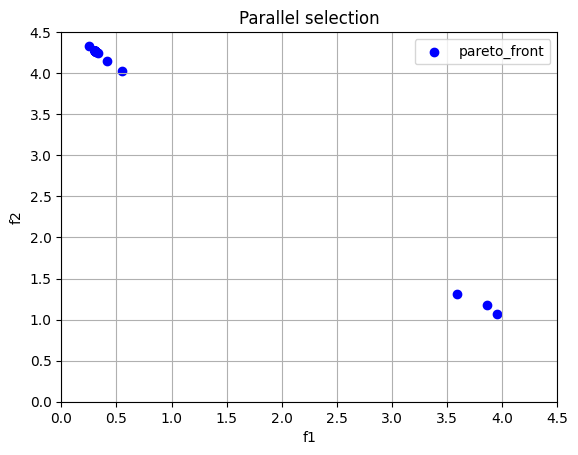

In [270]:
def main():
    pop_size = 100  # 种群大小
    generations = 100  # 代数
    crossover_rate = 0.8  # 交叉概率
    mutation_rate = 0.01  # 变异概率

    # 初始化种群
    population = init_population(pop_size)
    # 均分种群
    population1,population2 = population_split(population,0.5,shuffle= True)

    for gen in range(generations):
        new_population = []

        # 选择操作
        selected1 = select1(population1, int(pop_size/2))
        selected2 = select2(population2, int(pop_size/2))
        selected = selected1 + selected2

        # 交叉操作
        for i in range(0, pop_size, 2):
            if random.random() < crossover_rate:
                parent1, parent2 = selected[i], selected[i+1]
                child1, child2 = crossover(parent1, parent2)
                new_population.extend([child1, child2])
            else:
                new_population.extend([selected[i], selected[i+1]])

        # 变异操作
        for i in range(len(new_population)):
            new_population[i] = mutate(new_population[i], mutation_rate)

        # 更新种群
        population = new_population

         # 获取最终帕累托前沿解
    pareto_front = pareto_sort(population)
    
    # 输出帕累托前沿解并绘制分布图
    print("\nFinal Pareto front solutions:")
    for ind in pareto_front:
        print(f"Solution: {ind}, Objectives: {evaluate(ind)}")

    # 绘制帕累托前沿解分布
    plot_pareto_front(pareto_front)

if __name__ == "__main__":
    main()